### Filling Factor
- **ν**: Filling factor 1/2
- **Nk**: Number of k-points must be multiple of denominator for commensurability
- **Ne = Nk * ν**: Number of electrons

### Key Physics
- **Ground state competition**: in n=0 Landau level, competition between pfaffin-related states and composite Fermi liquids; in n=1 Landau level, Moore-Read states are the ground states.

In [1]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED
include("../Landau level triangular.jl")
using .LLT

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum()
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xlabel = "momentum block number",
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(blocks)
        x = Gk[2] * block_k1[i] + block_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        for e in energies[i]
            scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
        end
    end
    ax_top.xticks = top_ticks
    fig
end

plot_ed_spectrum (generic function with 1 method)

In [2]:
# Define 4×4 k-mesh (Nk=16) 

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]

# System parameters
Nk = 16         # Total number of k-points
Gk = (4, 4)     # Grid dimensions (G1_direction, G2_direction)
Ne = 8          # Ne electrons for this system, Ne=8 for 1/2 filling

=#

In [3]:
# Define 3×6 k-mesh (Nk=18) 
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4 5 5 5]

# System parameters
Nk = 18         # Total number of k-points
Gk = (3, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 6          # Ne electrons for this system


6

In [4]:
# Define 4×5 k-mesh (Nk=20) 

#

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4]

# System parameters
Nk = 20         # Total number of k-points
Gk = (4, 5)     # Grid dimensions (G1_direction, G2_direction)
Ne = 4          # Ne electrons for this system

#

4

In [5]:
# Define 4×6 k-mesh (Nk=24) 

#=

k_list = [0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3;
          0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5 6 6 6 6]

# System parameters
Nk = 24         # Total number of k-points
Gk = (4, 6)     # Grid dimensions (G1_direction, G2_direction)
Ne = 12          # Ne electrons for this system

=#

In [6]:
using LinearAlgebra
function pseudopotential(m::Int64)
    local sys_int = LandauInteraction()
    sys_int.V_intra = [fill(0.0, m); 1.0]
    sys_int.mix = 1.0

    local para = EDPara(k_list = k_list, Gk = Gk, V_int = sys_int)
    local scat = ED_sortedScatteringList_twobody(para);
    return MBSOperator{Float64}(scat; upper_triangular = true)
end

m_list = 0:20
ops = Vector{MBSOperator}(undef, length(m_list))
for i in eachindex(m_list)
    ops[i] = pseudopotential(m_list[i])
end

In [7]:
# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction((1, 0, 1, 0));

# use Haldane pseudopotential
sys_int.V_intra = [0.0; 1.0; 0.0; 1.0]

# show the pseudopotential decomposition of the gate-screened Coulomb interaction for reference
sys_int.D_l = 5.0                              # gate distance / magnetic length 
show( LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0) )
# sys_int.V_intra = LLT.pseudo_potential_decomposition.(0:10; D_l = sys_int.D_l, d_l = 0.0)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 1                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(k_list = k_list, Gk = Gk, 
    V_int = sys_int, FF_inf_angle = LLT.Landau_ff_inf(sys_int));

[1.501982636440383, 0.6221557340393984, 0.40664424293836865, 0.30158556536371806, 0.23776931630752113, 0.19444791767975755, 0.1629877940798242, 0.13908056457052326, 0.12030920054636296, 0.10520165028815111, 0.09280505933768239]

In [8]:
show( MomentumED.Combinatorics.binomial(Nk, Ne) / Nk)

blocks, block_k1, block_k2, k0number = 
    ED_momentum_block_division(para, ED_mbslist(para, (Ne,)));

# one-body terms are all zero in flat Landau level
scat = ED_sortedScatteringList_twobody(para);

242.25

In [9]:
Neigen = 10  # Number of eigenvalues to compute per block
energies = Vector{Vector{Float64}}(undef, length(blocks))
vectors = Vector{Vector{Vector{ComplexF64}}}(undef, length(blocks))
for i in eachindex(blocks)
    println("Processing block #$i with size $(length(blocks[i])), momentum $(block_k1[i]), $(block_k2[i])")
    energies[i], vectors[i] = EDsolve(blocks[i], scat; N = Neigen,
        showtime=true
    )
end

Processing block #1 with size 244, momentum 0, 0
  1.134145 seconds (903.63 k allocations: 47.817 MiB, 163.45% compilation time)
  7.328876 seconds (13.45 M allocations: 684.100 MiB, 1.70% gc time, 125.12% compilation time)
Processing block #2 with size 244, momentum 0, 1
  0.001959 seconds (270 allocations: 1.217 MiB)
  0.012645 seconds (3.88 k allocations: 2.018 MiB)
Processing block #3 with size 244, momentum 0, 2
  0.063376 seconds (285 allocations: 1.190 MiB, 45.18% gc time)
  0.029481 seconds (3.91 k allocations: 2.020 MiB)
Processing block #4 with size 244, momentum 0, 3
  0.002391 seconds (269 allocations: 1.161 MiB)
  0.030176 seconds (3.81 k allocations: 2.003 MiB)
Processing block #5 with size 244, momentum 0, 4
  0.002406 seconds (291 allocations: 1.315 MiB)
  0.035927 seconds (3.81 k allocations: 2.004 MiB)
Processing block #6 with size 240, momentum 1, 0
  0.002062 seconds (294 allocations: 1.197 MiB)
  0.034801 seconds (3.10 k allocations: 1.642 MiB)
Processing block #7 

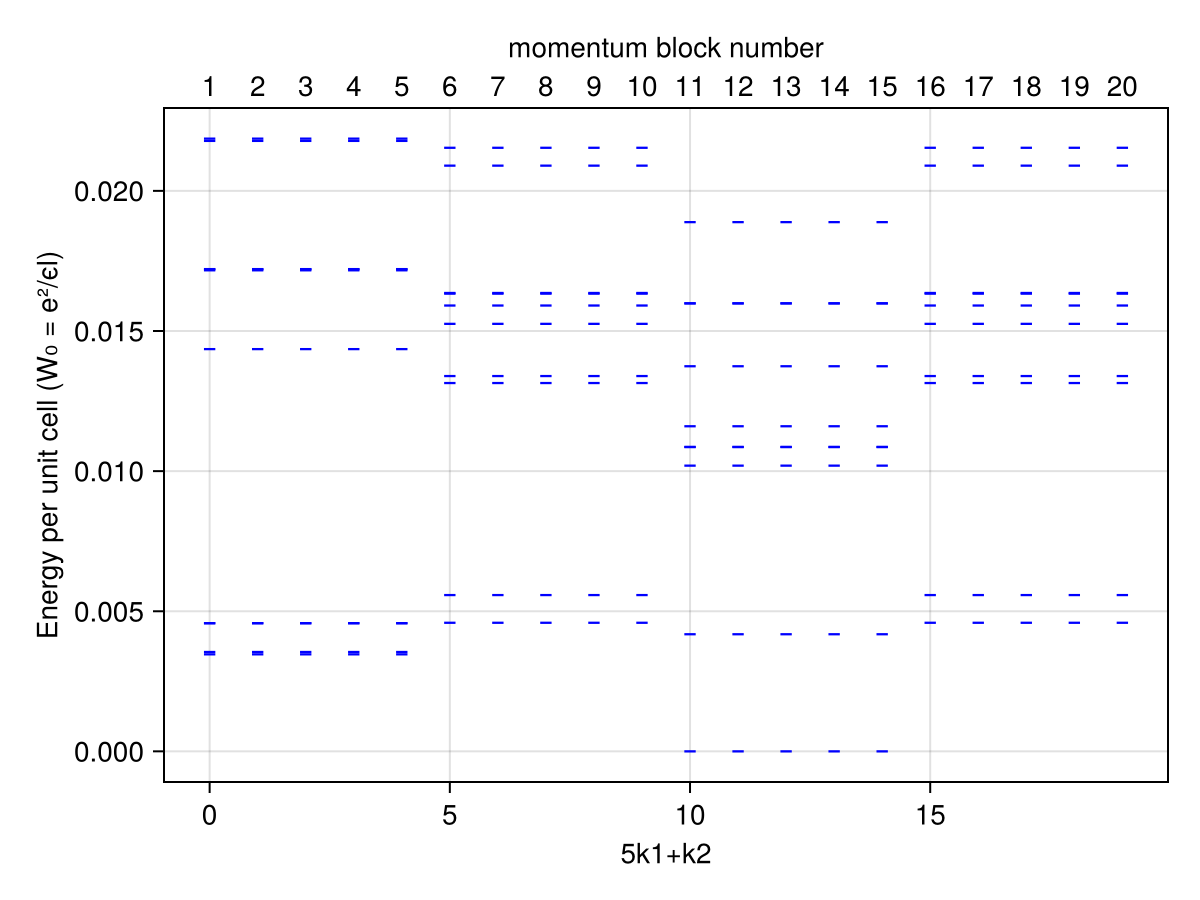

In [10]:
plot_ed_spectrum()

In [11]:
# check energies explicitly to see degeneracy.

bn = 11 # the block number to inspect
println("total momentum: ", block_k1[bn], "  ", block_k2[bn])
energies[bn]/Nk/LLT.W0

total momentum: 2  0


10-element Vector{Float64}:
 -2.838372519744513e-12
  0.004178820624791418
  0.010194725942039488
  0.010860487051012176
  0.010860487051012179
  0.011600266220434684
  0.013741437249133718
  0.01598586851265788
  0.015985868512658007
  0.018883281515046278

Compute and plot one-body reduced density matrix

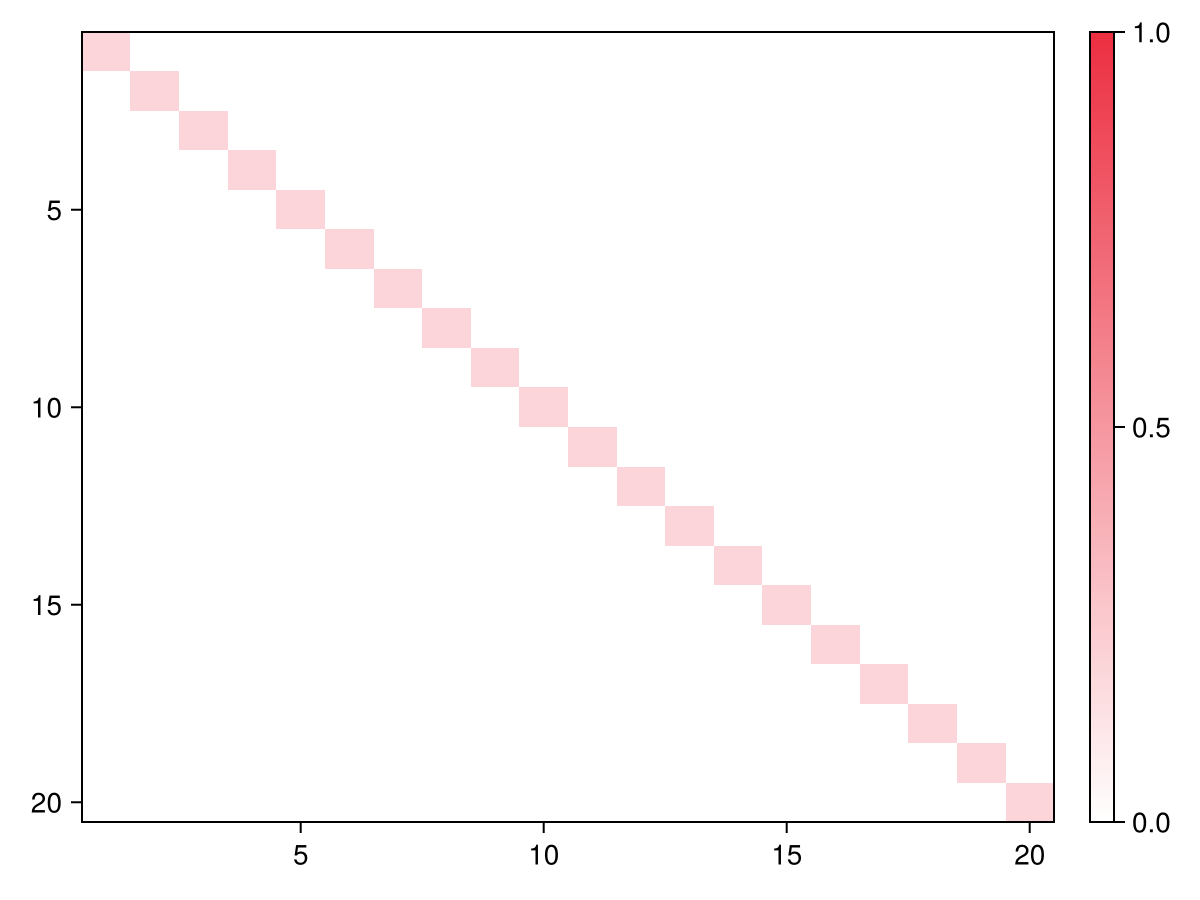

In [12]:
# plot the one-body reduced density matrix of the ground eigenstate in the first block
rdm = ED_onebody_rdm(blocks[bn], vectors[bn][1])

fig = Figure();
ax = Axis(fig[1, 1]; yreversed = true)
hm = heatmap!(ax, abs.(rdm); colorrange = (0,1), 
    colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
)
Colorbar(fig[1, 2], hm)
fig

Compute the expectation values of pseudo-potentials of angular momemta m

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21   0.287258 seconds (257.49 k allocations: 11.439 MiB, 30.98% compilation time)
12 13 14 15 16 17 18 19 20 21   0.287258 seconds (257.49 k allocations: 11.439 MiB, 30.98% compilation time)


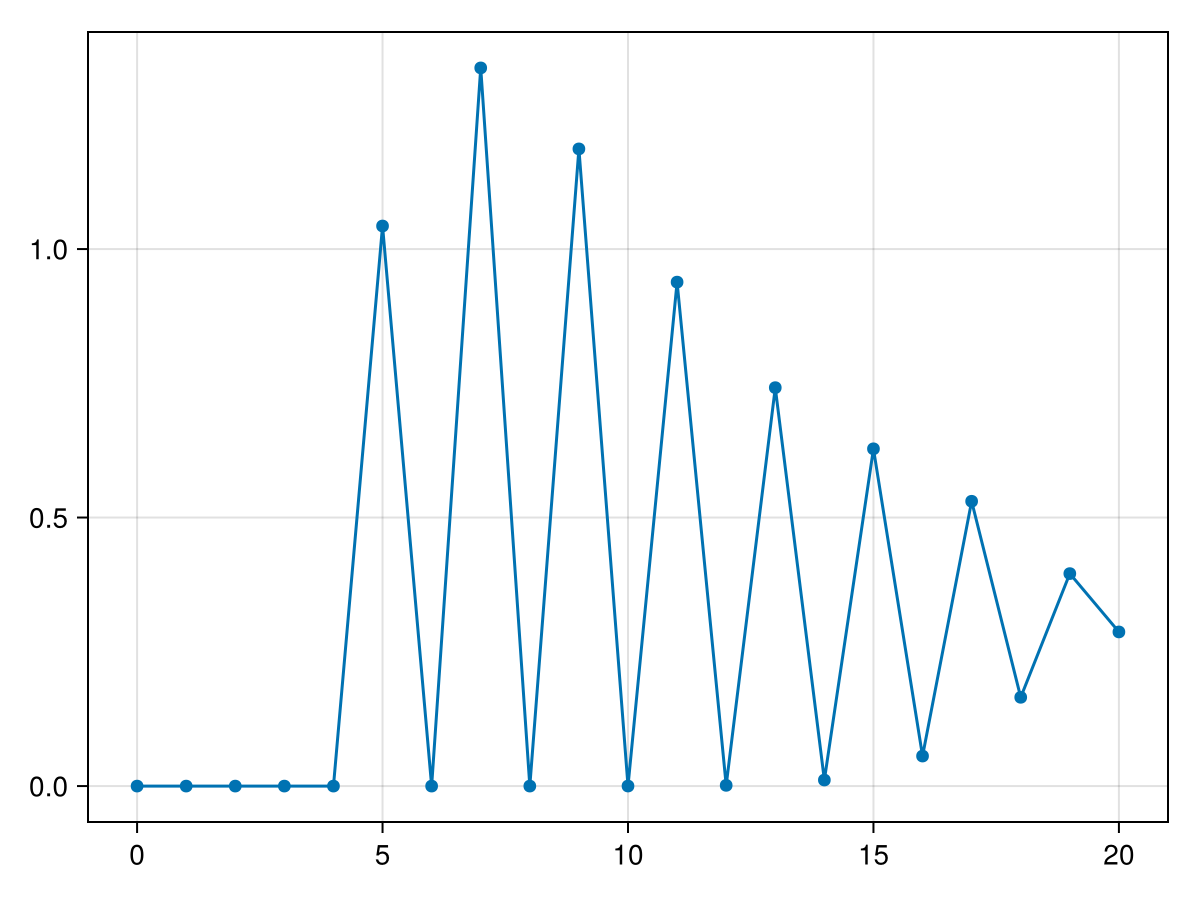

In [15]:
bn = 11
using MomentumED: create_state_mapping
mapping = create_state_mapping(blocks[bn])
myvec = MBS64Vector(vectors[bn][1], mapping)

E_m = zeros(Float64, length(m_list))
@time for i in eachindex(m_list)
    print(i, ' ')
    E_m[i] += ED_bracket(myvec, ops[i], myvec) |> real
end

display(scatterlines(m_list, E_m));

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21   2.552888 seconds (21.85 M allocations: 440.854 MiB, 10.85% gc time, 19.03% compilation time: 35% of which was recompilation)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21   2.112315 seconds (21.60 M allocations: 428.365 MiB, 2.58% gc time)
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21   1.971176 seconds (11.48 M allocations: 277.028 MiB, 2.53% gc time)
21   1.971176 seconds (11.48 M allocations: 277.028 MiB, 2.53% gc time)


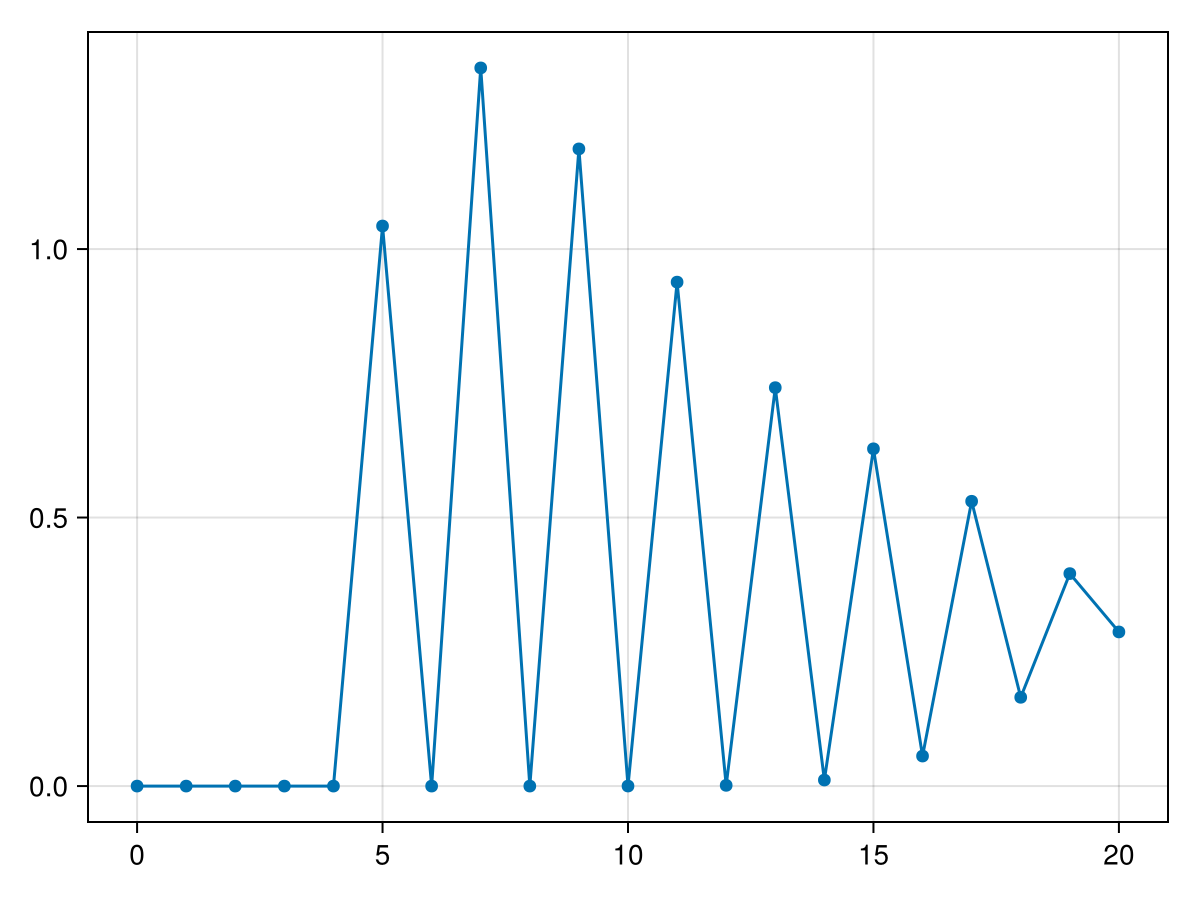

In [ ]:
bn = 11
using MomentumED: create_state_mapping, ED_apply
mapping = MomentumED.create_state_mapping(blocks[bn])
myvec = MBS64Vector(vectors[bn][1], mapping)

E_m = zeros(Float64, length(m_list))
@time for i in eachindex(m_list)
    print(i, ' ')
    E_m[i] += ED_bracket_threaded(myvec, ops[i], myvec) |> real
end

display(scatterlines(m_list, E_m));

In [24]:
opop = MBSOperator{Float64}(ops[1].scats[1:1]; upper_triangular = true)
opop.scats

1-element Vector{Scattering{2}}:
 2-body scattering: c†_out (2, 1) c_in (1, 2), Amp = 1.1102230246251566e-17 + 0.0im

Compute the many-body connection and the Wilson loop for many-body Chern number.

In [16]:
# twist angle path for the Wilson loop integral
N_shift = 5  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.2, 0.0)
 (0.2, 0.2)
 (0.0, 0.2)
 (0.0, 0.0)

In [20]:
bn = 11                     # block number
nstates = 1                # number of degenerating states

psi_before = reduce(hcat, vectors[bn][1:nstates])
ED_connection_gaugefixing!(psi_before)  # fix global phase
psi_after = similar(psi_before)

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    scat_list = ED_sortedScatteringList_twobody(para; kshift = path[i+1]);
    vecs = EDsolve(blocks[bn], scat_list; N = 6,
        showtime = false,
    )[2][1:nstates]
    psi_after .= reduce(hcat, vecs)
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step(blocks[bn], 
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.2, 0.0)
Inner product: amp = 1.0000000000000004, phase = -6.513980873977882e-16
path point #2 	 (0.2, 0.2)
Inner product: amp = 0.9999999999999991, phase = 0.21362830044410708
path point #3 	 (0.0, 0.2)
Inner product: amp = 0.9999999999999991, phase = 0.025132741228718433
path point #4 	 (0.0, 0.0)
Inner product: amp = 0.9999999999999998, phase = -0.18849555921538755


0.20000000000000248